In [1]:
import geopandas as gpd
gpd.options.use_pygeos=False
import pandas as pd

/home/lucas/miniconda3/envs/sips/lib/python3.7/site-packages/geopandas/_compat.py:78: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import os, json, geojson

In [3]:
root = '/home/lucas/repos/solar-pv-global-inventory'

In [4]:
ne = gpd.read_file(os.path.join(root,'data','ne_10m_countries.gpkg'))

In [5]:
#gdf = gpd.read_file(os.path.join(root,'data','ABCD_finalized.geojson'))

In [5]:
import glob

In [6]:
ne_prov = gpd.read_file(os.path.join(root,'data','ne_10m_admin_1_states_provinces.geojson'))

### Do SPOT

In [7]:
country_gj = ['AU','BR','CL','CA','CN','FR','GB','IN','US']

In [8]:
do_prov = ['AU','BR','CA','CN','IN','US']

#### approach
- open each gj, reduce 2 mp, jsoin on ne or ne_prov, groupby merge back to ne or ne_prov

In [9]:
fs_pre = sorted(glob.glob(os.path.join(root,'data','pre_handverify','Classifier_positives','*.geojson')))
fs_vetted = sorted(glob.glob(os.path.join(root,'data','pre_handverify','hand_vetted','*.geojson')))

In [10]:
fs_pre = {f.split('_')[-1].split('.')[0]:f for f in fs_pre}
fs_vetted = {f.split('_')[-2]:f for f in fs_vetted}

In [16]:
fs_pre

{}

In [11]:
import json
from shapely import geometry
import numpy as np

In [12]:
ne = ne[~ne.geometry.isna()]

In [13]:
gdf = gpd.read_file(fs_pre['E-E'])

KeyError: 'E-E'

In [15]:
mp = gdf.unary_union

In [16]:
len(list(mp))

16870

In [17]:
gdf = gpd.GeoDataFrame(geometry=list(mp), crs='epsg:4326')

In [19]:
import matplotlib.pyplot as plt

In [28]:
gdf.geometry.area

0        5.524752e-08
1        5.719291e-08
2        1.115314e-07
3        1.536152e-07
4        1.925424e-07
             ...     
16865    2.130214e-06
16866    1.739829e-05
16867    3.215720e-06
16868    6.871596e-06
16869    1.279202e-05
Length: 16870, dtype: float64

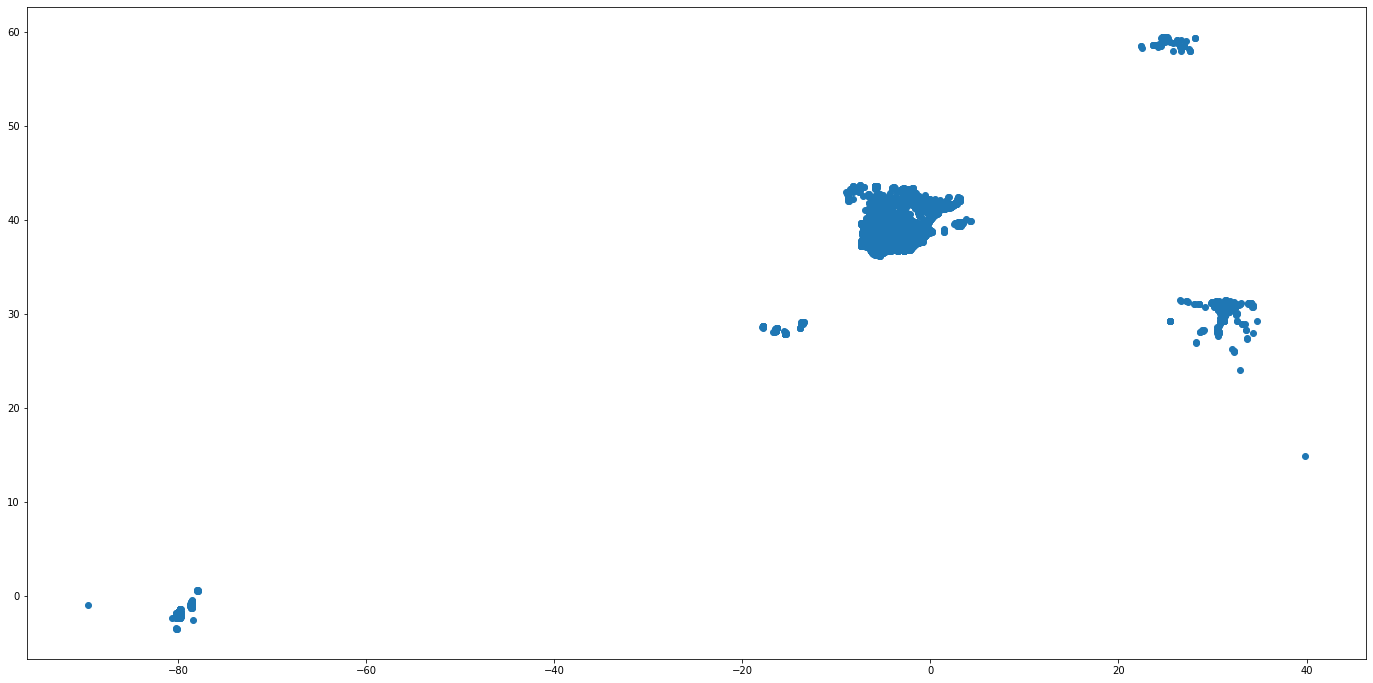

In [32]:
fig, ax = plt.subplots(1,1,figsize=(24,12))
gdf.representative_point().plot(ax=ax)
#ax.set_xlim([-20,20])
#ax.set_ylim([30,50])
plt.show()

In [33]:
gdf['geometry'] = gdf['geometry'].representative_point()

In [34]:
gdf = gpd.sjoin(gdf,ne[['geometry','ISO_A2']], how='left')

In [35]:
gdf

,geometry,index_right,ISO_A2
0,POINT (-80.20251 -3.54167),136.0,EC
1,POINT (-80.17238 -3.49425),136.0,EC
2,POINT (-80.18212 -3.47610),136.0,EC
3,POINT (-80.19139 -3.46293),136.0,EC
4,POINT (-78.44752 -2.60453),136.0,EC
...,...,...,...
16865,POINT (-1.99021 39.43076),67.0,ES
16866,POINT (-3.13616 39.42951),67.0,ES
16867,POINT (-2.12500 39.43021),67.0,ES
16868,POINT (-3.62920 39.43103),67.0,ES


In [14]:
ne['N_obs_SPOT'] = np.nan
ne['N_T_SPOT'] = np.nan
ne_prov['N_obs_SPOT'] = np.nan
ne_prov['N_T_SPOT'] = np.nan

In [15]:
ne_prov = ne_prov.set_index('iso_3166_2', drop=False)
ne = ne.set_index('ISO_A2', drop=False)

In [41]:
def load_listgj(fpath):
    gdf = json.load(open(fpath,'r'))['features']
    gdf = [geometry.shape(ft) for ft in gdf]
    return gpd.GeoDataFrame(geometry=gdf)

def do_gdf(gdf_sub,col,key):
    _mp = gdf_sub.unary_union
    gdf_sub = gpd.GeoDataFrame(geometry=list(_mp), crs='epsg:4326')
    gdf_sub['geometry'] = gdf_sub['geometry'].representative_point()
    _mp = None


    if key in do_prov:
        # do it in province
        gdf_sub = gpd.sjoin(gdf_sub,ne_prov[['geometry','iso_3166_2']], how='left')
    else:
        gdf_sub = gpd.sjoin(gdf_sub,ne[['geometry','ISO_A2']], how='left')
        
    if key in do_prov:
        ind = gdf_sub.groupby('iso_3166_2').size().index.values
        ind = [ii for ii in ind if ii[0]==key[0]]
        ne_prov.loc[ind,col] = gdf_sub.groupby('iso_3166_2').size()
        return ind
    else:
        ind = gdf_sub.groupby('ISO_A2').size().index.values
        ind = [ii for ii in ind if ii[0]==key[0]]
        ne.loc[ind,col] = gdf_sub.groupby('ISO_A2').size()
        return ind
        
    

for kk in list(fs_pre.keys()):

    
    # do pre
    print ('Running pre:',kk)
    gdf = gpd.read_file(fs_pre[kk])
    ind = do_gdf(gdf,'N_obs_SPOT',kk)
    
    print ('Running post:',kk)
    if kk!='O-O':
        gdf = load_listgj(fs_vetted[kk])
        null = do_gdf(gdf,'N_T_SPOT',kk)
    
    if kk in do_prov:
        print (ne_prov.loc[ind,['iso_3166_2','N_obs_SPOT','N_T_SPOT']])
    else:
        print (ne.loc[ind,['ISO_A2','N_obs_SPOT','N_T_SPOT']])

        
    # kernel bork doing both at once... do one at a time
        
    

Running pre: A-B
Running post: A-B
       ISO_A2  N_obs_SPOT  N_T_SPOT
ISO_A2                             
AE         AE       171.0      20.0
AF         AF        35.0       2.0
AG         AG         2.0       2.0
AL         AL        11.0       1.0
AM         AM        14.0       4.0
AO         AO       141.0       2.0
AS         AS         1.0       NaN
AT         AT       235.0      32.0
AX         AX         1.0       NaN
AZ         AZ       104.0       3.0
Running pre: AU
Running post: AU
           iso_3166_2  N_obs_SPOT  N_T_SPOT
iso_3166_2                                 
AU-ACT         AU-ACT         5.0       NaN
AU-NSW         AU-NSW       605.0      19.0
AU-NSW         AU-NSW       605.0      19.0
AU-NT           AU-NT        46.0      12.0
AU-QLD         AU-QLD       868.0      10.0
AU-SA           AU-SA       595.0      39.0
AU-TAS         AU-TAS       176.0       1.0
AU-VIC         AU-VIC      1253.0      23.0
AU-WA           AU-WA       647.0       5.0
Running pre: BR


In [42]:
ne[['ISO_A2','N_obs_SPOT','N_T_SPOT']].to_csv(os.path.join(root,'data','ne_SPOT.csv'))

In [43]:
ne_prov[['iso_3166_2','N_obs_SPOT','N_T_SPOT']].to_csv(os.path.join(root,'data','ne_prov_SPOT.csv'))

### split out AR and KZ

In [ ]:
ar = gpd.read_file(os.path.join(root,'data','pre_handverify','additional_AR_NZ_CD_ID_ET.geojson'))

In [ ]:
kz = gpd.read_file(os.path.join(root,'data','pre_handverify','additional_KZ.geojson'))

In [ ]:
ne = ne[~ne.geometry.isna()]

In [ ]:
ar = gpd.sjoin(ar,ne[['ISO_A2','geometry']], how='left')

In [ ]:
ar = ar.reset_index().groupby('index').nth(0)

In [ ]:
for iso2 in list(ar.ISO_A2.unique()):
    ar.loc[ar.ISO_A2==iso2,:].to_file(os.path.join(root,'data','pre_handverify',iso2+'.geosjon'),driver='GeoJSON')

### Do Deployment precision at iso-3166-2

In [ ]:
ne_prov.columns

In [ ]:
do_prov = ['AU','BR','CA','CN','IN','US']

In [ ]:
multipart = ['CL','PK','CN-54','CN-65']

In [ ]:
all_files = sorted(glob.glob(os.path.join(root,'data','pre_handverify','*.geojson')))

In [ ]:
all_iso2 = sorted(list(set([f.split('/')[-1][0:2] for f in all_files])))

In [ ]:
records = []

In [ ]:
all_iso2

In [ ]:
gdf_f = gpd.read_file(all_files[0])

In [ ]:
gdf_f

### Approach 
- get all labels
- for each geography, get the labels subset

In [ ]:
from pathlib import Path
import json
import pandas as pd

In [ ]:
root

In [ ]:
label_paths = []
label_paths += [path for path in Path('/home/lucas/repos/Solar_PV/S2_pics_A').rglob('*/labels.json')]
label_paths += [path for path in Path('/home/lucas/repos/Solar_PV/S2_pics_C_gt5').rglob('*/labels.json')]
label_paths += [path for path in Path('/home/lucas/repos/Solar_PV/hand_labelling_client').rglob('*/labels.json')]
label_paths += [Path('/home/lucas/repos/Solar_PV/hand_labelling_client/all_labels.json')]

In [ ]:
all_labels = []
for path in label_paths:
    all_labels += json.load(open(path,'r'))

In [ ]:
len(all_labels)

In [ ]:
len([ll for ll in all_labels if ll['label']==1])

In [ ]:
json.dump(all_labels, open(os.path.join(root,'data','all_labels.json'),'w'))

### Prepare label_df

In [ ]:
label_df = pd.DataFrame.from_records(all_labels)

In [ ]:
label_df['unixfname'] = label_df['fname'].str.replace('\\','/')
label_df['unixfname'] = label_df['unixfname'].str.replace('꞉',':')
label_df['unixfname'] = label_df['unixfname'].str.split('/').str[-1].str.split('__').str[0]

In [ ]:
label_df.loc[label_df['unixfname'].str.contains('2000-0'),'unixfname'] = label_df.loc[label_df['unixfname'].str.contains('2000-0'),'unixfname'].str.replace('--','-^').str.replace('-',':').str.replace('^','-')

In [ ]:
label_df['unixfname']=label_df['unixfname'].str.split(',')

In [ ]:
label_df=label_df.explode('unixfname')

In [ ]:
label_df = label_df.drop_duplicates(subset=['unixfname'])

In [ ]:
label_df['unixfname']

In [ ]:
gdf_f = gpd.read_file(all_files[0])

In [ ]:
gdf_f['S2_ids_0'].str.split(',').explode()

In [ ]:
label_df['iso2']=''
label_df['iso_prov']=''

In [ ]:
len(all_files)

In [ ]:
for f in all_files:
    iso2=f.split('/')[-1][0:2]
    
    if iso2 in do_prov:
        iso_prov = f.split('/')[-1][0:5]

    else:
        iso_prov='none'

    # load file
    gdf_f = gpd.read_file(f)
    if iso2=='KZ':
        col_name='primary_id'
    else:
        col_name='S2_ids_0'

    label_df.loc[label_df['unixfname'].isin(gdf_f[col_name].str.split(',').explode()),'iso2']=iso2
    label_df.loc[label_df['unixfname'].isin(gdf_f[col_name].str.split(',').explode()),'iso_prov']=iso_prov
    
    print (iso2,iso_prov,'cols',[cc for cc in gdf_f.columns if 'S2_ids' in cc],len(label_df.loc[label_df['iso2']==iso2,:]), label_df.loc[label_df['iso2']==iso2,'label'].sum())

In [ ]:
(label_df['iso2']=='').sum()

In [ ]:
import descarteslabs as dl

In [ ]:
import multiprocessing as mp

In [ ]:
raster_client = dl.Raster()

In [ ]:
missing_keys = label_df.loc[label_df['iso2']=='','unixfname'].str.split('_').str[0].values.tolist()

In [ ]:
tile= raster_client.dltile(missing_keys[0])
shp = geometry.shape(tile['geometry'])
#return {'key':key,'centroid':shp.centroid()}

In [ ]:
shp.centroid.xy

In [ ]:
N_workers = 4
chunk = (len(missing_keys)//N_workers)+1
key_chunks = [[missing_keys[ii*chunk:(ii+1)*chunk]] for ii in range(N_workers)]

In [ ]:
pool = mp.Pool(N_workers)

In [ ]:
def worker(key_chunk):
    rc=dl.Raster()
    records = []
    for ii_k,key in enumerate(key_chunk):
        if ii_k %1000==0:
            print (ii_k)
        tile = rc.dltile(key)
        shp = geometry.shape(tile['geometry'])
        records.append({'key':key,'centroid':shp.centroid})
    return records

In [ ]:
assemble_records = pool.starmap(worker,key_chunks)

In [ ]:
flat_records = [item for sublist in assemble_records for item in sublist]

In [ ]:
len(flat_records)

In [ ]:
new_record_df = pd.DataFrame.from_records(flat_records)

In [ ]:
new_record_df = new_record_df.drop_duplicates(subset=['key'])

In [ ]:
new_record_gdf = gpd.GeoDataFrame(new_record_df, geometry=new_record_df['centroid'], crs='epsg:4326')

In [ ]:
new_record_gdf = gpd.sjoin(new_record_gdf,ne_prov[['geometry','iso_3166_2','iso_a2']], how='left')

In [ ]:
label_df['key'] = label_df['unixfname'].str.split('_').str[0]

In [ ]:
label_df

In [ ]:
new_record_gdf

In [ ]:
label_df = label_df.merge(new_record_gdf[['key','iso_3166_2','iso_a2']], how='left',left_on='key',right_on='key')

In [ ]:
label_df.loc[label_df['iso2']=='','iso2'] = label_df.loc[label_df['iso2']=='','iso_a2']
label_df.loc[label_df['iso_prov']=='','iso_prov'] = label_df.loc[label_df['iso_prov']=='','iso_3166_2']

In [ ]:
label_df = label_df.drop(columns=['key','iso_3166_2','iso_a2'])

In [ ]:
label_df.to_csv(os.path.join(root,'data','label_df.csv'))

### Use label_df

In [ ]:
ne_prov = gpd.read_file(os.path.join(root,'data','ne_10m_admin_1_states_provinces.geojson'))

In [ ]:
do_prov = ['AU','BR','CA','CN','IN','US']

In [44]:
label_df = pd.read_csv(os.path.join(root,'data','label_df.csv'))

In [46]:
ne = ne.merge(pd.DataFrame(label_df.groupby('iso2').size()), how='left',left_index=True,right_index=True).rename(columns={0:'N_obs_S2'})

In [47]:
ne = ne.merge(pd.DataFrame(label_df[['iso2','label']].groupby('iso2').sum()), how='left',left_index=True,right_index=True).rename(columns={'label':'N_T_S2'})

In [84]:
ne['N_T_SPOT'] = ne['N_T_SPOT'].fillna(0)

In [85]:
ne['por_S2'] = ne['N_T_S2']/ne['N_obs_S2']
ne['por_SPOT'] = ne['N_T_SPOT']/ne['N_obs_SPOT']

In [49]:
ne_prov = ne_prov.merge(pd.DataFrame(label_df.groupby('iso_prov').size()), how='left',left_index=True,right_index=True).rename(columns={0:'N_obs_S2'})

In [50]:
ne_prov = ne_prov.merge(pd.DataFrame(label_df[['iso_prov','label']].groupby('iso_prov').sum()), how='left',left_index=True,right_index=True).rename(columns={'label':'N_T_S2'})

In [86]:
ne_prov['N_T_SPOT'] = ne_prov['N_T_SPOT'].fillna(0)

In [87]:
ne_prov['por_S2'] = ne_prov['N_T_S2']/ne_prov['N_obs_S2']
ne_prov['por_SPOT'] = ne_prov['N_T_SPOT']/ne_prov['N_obs_SPOT']

In [94]:
ne['por_SPOT'] = ne['por_SPOT'].fillna(0)
ne_prov['por_SPOT'] = ne_prov['por_SPOT'].fillna(0)

In [52]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from geopandas.plotting import plot_polygon_collection

In [53]:

ne['log10_obs_S2'] = np.log10(ne['N_obs_S2'])
ne['log10_obs_SPOT'] = np.log10(ne['N_obs_SPOT'])
ne_prov['log10_obs_S2'] = np.log10(ne_prov['N_obs_S2'])
ne_prov['log10_obs_SPOT'] = np.log10(ne_prov['N_obs_SPOT'])

In [110]:
vmax_S2=4
vmax_SPOT=4.5
por_max_S2 = 1
por_max_SPOT = 0.5

In [54]:
ne['log10_obs_S2'].max(),ne['log10_obs_SPOT'].max()

(4.3968790352215565, 4.297935506359647)

In [83]:
por_max_SPOT

0.5

In [111]:
def conv_rgb_S2(row):
    if np.isnan(row['log10_obs_S2']):
        return [0,0,0,1] #'#%02x%02x%02x' % 
    else:
        b = row['log10_obs_S2']/vmax_S2
        r = row['por_S2']*b
        g = (1-row['por_S2'])*b
    return [r,g,b,1] #'#%02x%02x%02x' % 

def conv_rgb_SPOT(row):
    if np.isnan(row['log10_obs_SPOT']):
        return [0,0,0,1] #'#%02x%02x%02x' % 
    else:
        b = row['log10_obs_SPOT']/vmax_SPOT
        r = np.clip(row['por_SPOT']/por_max_SPOT,0,1)*b
        g = (1-np.clip(row['por_SPOT']/por_max_SPOT,0,1))*b
        
    arr = np.array([r,g,b,1])
    if ((arr>1).sum()+ (arr<0).sum())>0:
        print (row)
    return [r,g,b,1] #'#%02x%02x%02x' % 

In [80]:
ne['log10_obs_SPOT'] = ne['log10_obs_SPOT'].fillna(0)

In [112]:
ne['color_S2'] = ne.apply(lambda row: conv_rgb_S2(row), axis=1)
ne_prov['color_S2'] = ne_prov.apply(lambda row: conv_rgb_S2(row), axis=1)
ne['color_SPOT'] = ne.apply(lambda row: conv_rgb_SPOT(row), axis=1)
ne_prov['color_SPOT'] = ne_prov.apply(lambda row: conv_rgb_SPOT(row), axis=1)

In [ ]:
ne = ne[~ne.geometry.isna()]

In [71]:
def leg_gen(dim):
    a = np.stack([np.linspace(0,1,dim)]*dim)
    P = np.linspace(1,0,dim)
    R = np.stack([P]*dim).T
    G = 1-R
    B = np.ones((dim,dim))
    return np.moveaxis(np.stack([R,G,B]),0,-1)*np.moveaxis(np.stack([a]*3),0,-1)

In [115]:
np.log10(10**4)

4.0

In [72]:
leg_arr = leg_gen(50)

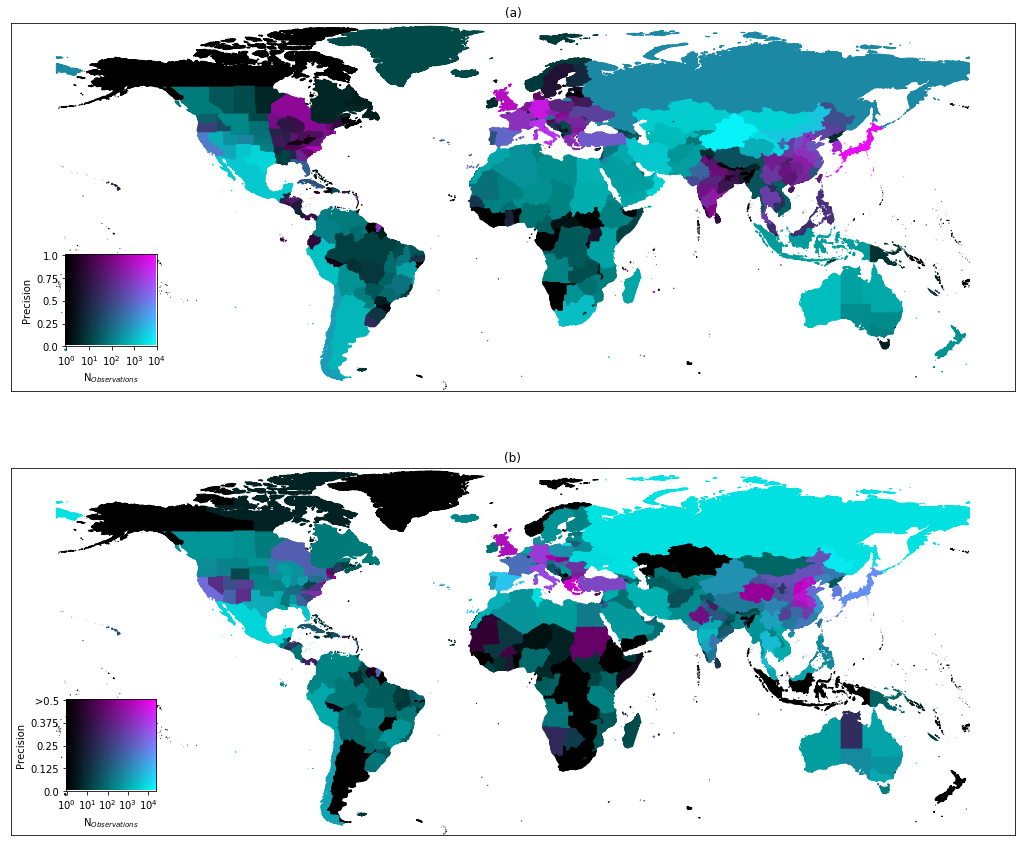

In [117]:
fig, axs = plt.subplots(2,1,figsize=(18,15))

#plot basemap
ne.plot(ax=axs[0], color='#d1d1d1')
ne.plot(ax=axs[1], color='#d1d1d1')

#plot polys S2
plot_polygon_collection(axs[0], ne.loc[~ne['ISO_A2'].isin(do_prov),'geometry'], color=ne.loc[~ne['ISO_A2'].isin(do_prov),'color_S2'])
plot_polygon_collection(axs[0], ne_prov.loc[ne_prov['iso_a2'].isin(do_prov),'geometry'], color=ne_prov.loc[ne_prov['iso_a2'].isin(do_prov),'color_S2'])

#plopt polys SPOT
plot_polygon_collection(axs[1], ne.loc[~ne['ISO_A2'].isin(do_prov),'geometry'], color=ne.loc[~ne['ISO_A2'].isin(do_prov),'color_SPOT'])
plot_polygon_collection(axs[1], ne_prov.loc[ne_prov['iso_a2'].isin(do_prov),'geometry'], color=ne_prov.loc[ne_prov['iso_a2'].isin(do_prov),'color_SPOT'])

#ne.loc[(~ne['por'].isna()) &(ne['N_T']>5 ) & (~ne['ISO_A2'].isin(do_prov)),:].plot(ax=axs[0], column='por', cmap='magma')
#ne_prov.loc[(~ne_prov['por'].isna()) & (ne_prov['N_T']>5) & (ne_prov['iso_a2'].isin(do_prov)),:].plot(ax=axs[0], column='por', cmap='magma')
#ne.loc[(~ne['por'].isna()) &(ne['N_T']<=5 ) & (~ne['ISO_A2'].isin(do_prov)),:].plot(ax=axs[0], column='log10_obs', cmap='bone', vmax=4)
#ne_prov.loc[(~ne_prov['por'].isna()) & (ne_prov['N_T']<=5) & (ne_prov['iso_a2'].isin(do_prov)),:].plot(ax=axs[0], column='log10_obs', cmap='bone', vmax=4)
ins1 = axs[0].inset_axes([0,0.12,0.2,0.25])
ins2 = axs[1].inset_axes([0,0.12,0.2,0.25])

ins1.imshow(leg_arr)
ins2.imshow(leg_arr)

ins1.set_xticks([ii*(50/4.) for ii in range(5)])
ins1.set_xticklabels([f'10$^{ii}$' for ii in range(5)])
ins1.set_yticks([ii*12.5 for ii in range(5)])
ins1.set_yticklabels([str(1-ii*12.5/50) for ii in range(5)])
ins1.set_ylabel('Precision')
ins1.set_xlabel('N$_{Observations}$')

ins2.set_xticks([ii*(45/4) for ii in range(5)])
ins2.set_xticklabels([f'10$^{ii}$' for ii in range(5)])
ins2.set_yticks([ii*(50/4) for ii in range(5)])
ins2.set_yticklabels(['0.0','0.125','0.25','0.375','>0.5'][::-1])
ins2.set_ylabel('Precision')
ins2.set_xlabel('N$_{Observations}$')



axs[0].set_ylim([-60,85])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_ylim([-60,85])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[0].set_title('(a)')
axs[1].set_title('(b)')
plt.savefig(os.path.join(root,'makefigs','deploy_precision.png'))
plt.show()

In [ ]:
(gdf['area']>1e4).sum()

In [ ]:
gdf['area'].medan()

In [ ]:
gdf[gdf['area']>1e4]['capacity_mw'].sum()/283000